# 2 Extract speech and conversation from audio files

For speech recognition we use OpenAI's [Whisper](https://github.com/openai/whisper) model.
And pyAnnote to identify different speakers in the audio file.



This code here is based on prototypes developed at Sage IDEMS hackathon in 2023 
https://github.com/chilledgeek/ethical_ai_hackathon_2023


In [ ]:
import os
import sys

project_root = os.path.join("..")
sys.path.append(project_root)

import time
import json
import pandas as pd
from src.utils import *
# Import specific modules for better readability
from src.utils.io_utils import getProcessedVideos, saveProcessedVideos
from src.utils.audio import convert_video_to_audio_moviepy, find_f0
from src.utils.speech import whisper_transcribe
from src.utils.diarization import diarize_audio, load_rttm
from src.config import PATH_CONFIG
from src.utils.notebook_utils import display_config_info, ensure_dir_exists

In [2]:
# Get paths from config - override here if needed
videos_in = PATH_CONFIG['videos_in']
data_out = PATH_CONFIG['data_out']

# Ensure output directory exists
if ensure_dir_exists(data_out):
    print(f"Created output directory: {data_out}")

# Display configuration information
display_config_info(videos_in, data_out, "Audio Processing Configuration")


## Audio Processing Configuration
    
| Configuration | Value | Status |
|---------------|-------|--------|
| Input Videos | `c:\Users\caspar\OneDrive\LegoGPI\babyjokes\LookitLaughter.test` | ✅ exists |
| Output Data | `c:\Users\caspar\OneDrive\LegoGPI\babyjokes\data\1_interim` | ✅ exists |
| Video Count | 54 videos | |

You can change these paths by modifying the `PATH_CONFIG` in `src/config.py` 
or by overriding them in this notebook.


In [3]:
demo_data = PATH_CONFIG['demo_data']
AUDIO_FILE = os.path.join(demo_data, "2UWdXP.joke1.rep2.take1.Peekaboo.mp3")
AUDIO_FILE2 = os.path.join(demo_data, "2UWdXP.joke2.rep1.take1.NomNomNom.mp3")
testset = [AUDIO_FILE, AUDIO_FILE2]

In [4]:
processedvideos = getProcessedVideos(data_out)
processedvideos.head()

Found existing processedvideos.xlsx with 54 rows.


,VideoID,ChildID,JokeType,JokeNum,JokeRep,JokeTake,HowFunny,LaughYesNo,Frames,FPS,...,Faces.file,Speech.when,Speech.file,Diary.file,Diary.when,LastError,annotatedVideo,annotated.when,FrameCount,Keypoints.normed
0,2UWdXP.joke1.rep2.take1.Peekaboo_h265.mp4,2UWdXP,Peekaboo,1,2,1,Slightly funny,No,NaN,14.232999,...,NaN,2025-04-03 19:56:09,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...,NaN,NaN,NaN,NaN,NaN,216,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...
1,2UWdXP.joke1.rep3.take1.Peekaboo_h265.mp4,2UWdXP,Peekaboo,1,3,1,Slightly funny,No,NaN,14.263979,...,NaN,2025-04-03 19:56:10,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...,NaN,NaN,NaN,NaN,NaN,150,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...
2,2UWdXP.joke2.rep1.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,1,1,Funny,No,NaN,12.275790,...,NaN,2025-04-03 19:56:11,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...,NaN,NaN,NaN,NaN,NaN,89,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...
3,2UWdXP.joke2.rep2.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,2,1,Slightly funny,No,NaN,13.920731,...,NaN,2025-04-03 19:56:11,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...,NaN,NaN,NaN,NaN,NaN,95,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...
4,2UWdXP.joke2.rep3.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,3,1,Slightly funny,No,NaN,14.010793,...,NaN,2025-04-03 19:56:14,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...,NaN,NaN,NaN,NaN,NaN,132,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...


## 2.1 Audio extraction with moviepy

The first step is simple. We extract the audio from each video and save it as `mp3` or `wav`. We will use the `moviepy` library to do this. 
This will be helpful for later analysis and regenerating labeled videos with audio.

Note that `moviepy` is a wrapper around `ffmpeg` and `ffmpeg` needs to be installed separately. 

`conda install ffmpeg moviepy`

In [5]:
forceaudio = False
#output_ext="mp3"
output_ext="wav"

for index, r in processedvideos.iterrows():
    if forceaudio or pd.isnull(r["Audio.file"]):
        audiopath = convert_video_to_audio_moviepy(videos_in,r["VideoID"], data_out, output_ext=output_ext)
        r["Audio.file"] = audiopath
        r["Audio.when"] = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
        #update this row in processedvideos dataframe
        processedvideos.loc[index] = r
    else:
        print("Audio already extracted for video: ", r["VideoID"])
        

saveProcessedVideos(processedvideos, data_out)
processedvideos.head()

Audio already extracted for video:  2UWdXP.joke1.rep2.take1.Peekaboo_h265.mp4
Audio already extracted for video:  2UWdXP.joke1.rep3.take1.Peekaboo_h265.mp4
Audio already extracted for video:  2UWdXP.joke2.rep1.take1.NomNomNom_h265.mp4
Audio already extracted for video:  2UWdXP.joke2.rep2.take1.NomNomNom_h265.mp4
Audio already extracted for video:  2UWdXP.joke2.rep3.take1.NomNomNom_h265.mp4
Audio already extracted for video:  2UWdXP.joke3.rep2.take1.ThatsNotAHat_h265.mp4
Audio already extracted for video:  2UWdXP.joke3.rep3.take1.ThatsNotAHat_h265.mp4
Audio already extracted for video:  2UWdXP.joke4.rep1.take1.TearingPaper_h265.mp4
Audio already extracted for video:  2UWdXP.joke4.rep2.take1.TearingPaper_h265.mp4
Audio already extracted for video:  2UWdXP.joke4.rep3.take1.TearingPaper_h265.mp4
Audio already extracted for video:  2UWdXP.joke5.rep1.take1.ThatsNotACat_h265.mp4
Audio already extracted for video:  2UWdXP.joke5.rep2.take1.ThatsNotACat_h265.mp4
Audio already extracted for video

,VideoID,ChildID,JokeType,JokeNum,JokeRep,JokeTake,HowFunny,LaughYesNo,Frames,FPS,...,Faces.file,Speech.when,Speech.file,Diary.file,Diary.when,LastError,annotatedVideo,annotated.when,FrameCount,Keypoints.normed
0,2UWdXP.joke1.rep2.take1.Peekaboo_h265.mp4,2UWdXP,Peekaboo,1,2,1,Slightly funny,No,NaN,14.232999,...,NaN,2025-04-03 19:56:09,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...,NaN,NaN,NaN,NaN,NaN,216,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...
1,2UWdXP.joke1.rep3.take1.Peekaboo_h265.mp4,2UWdXP,Peekaboo,1,3,1,Slightly funny,No,NaN,14.263979,...,NaN,2025-04-03 19:56:10,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...,NaN,NaN,NaN,NaN,NaN,150,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...
2,2UWdXP.joke2.rep1.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,1,1,Funny,No,NaN,12.275790,...,NaN,2025-04-03 19:56:11,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...,NaN,NaN,NaN,NaN,NaN,89,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...
3,2UWdXP.joke2.rep2.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,2,1,Slightly funny,No,NaN,13.920731,...,NaN,2025-04-03 19:56:11,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...,NaN,NaN,NaN,NaN,NaN,95,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...
4,2UWdXP.joke2.rep3.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,3,1,Slightly funny,No,NaN,14.010793,...,NaN,2025-04-03 19:56:14,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...,NaN,NaN,NaN,NaN,NaN,132,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...


## 2.2 Speech-to-text 


### 2.2.1 How not do to it  

We tried [SpeechBrain]((https://github.com/speechbrain/speechbrain), [Speech Recognition](https://github.com/Uberi/speech_recognition) and [Sphinx](https://github.com/cmusphinx/pocketsphinx). None of them worked out of the box. Speechbrain was fiddly and not very accurate (with default settings). Rather than trying to improve it. Let's try the OpenAI Whisper model instead.

See our [version 0.5alpha](https://github.com/InfantLab/babyjokes/releases/tag/v0.5alpha-sage) for the code.

### 2.2.2 Speech-to-text using OpenAI Whisper 

There is a free version of the [OpenAI Whisper](https://github.com/openai/whisper) model. It is multilingual (xx languages) and comes in a range of different sizes (and accuracies). We'll try the `base` model. 

Simple tutorial: https://analyzingalpha.com/openai-whisper-python-tutorial 

In [6]:
import whisper
model = whisper.load_model("base")

In [7]:
# We can use the imported function directly from our new module
# No need to redefine it here

In [8]:
for index, r in processedvideos.iterrows():
    if pd.isnull(r["Speech.file"]) and not pd.isnull(r["Audio.file"]):
        speechpath, result = whisper_transcribe(r["Audio.file"], save_path=data_out)
        r["Speech.file"] = speechpath
        r["Speech.when"] = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
        #update this row in processedvideos dataframe
        processedvideos.loc[index] = r
        
saveProcessedVideos(processedvideos, data_out)

In [9]:
processedvideos.head()

,VideoID,ChildID,JokeType,JokeNum,JokeRep,JokeTake,HowFunny,LaughYesNo,Frames,FPS,...,Faces.file,Speech.when,Speech.file,Diary.file,Diary.when,LastError,annotatedVideo,annotated.when,FrameCount,Keypoints.normed
0,2UWdXP.joke1.rep2.take1.Peekaboo_h265.mp4,2UWdXP,Peekaboo,1,2,1,Slightly funny,No,NaN,14.232999,...,NaN,2025-04-03 19:56:09,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...,NaN,NaN,NaN,NaN,NaN,216,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...
1,2UWdXP.joke1.rep3.take1.Peekaboo_h265.mp4,2UWdXP,Peekaboo,1,3,1,Slightly funny,No,NaN,14.263979,...,NaN,2025-04-03 19:56:10,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...,NaN,NaN,NaN,NaN,NaN,150,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...
2,2UWdXP.joke2.rep1.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,1,1,Funny,No,NaN,12.275790,...,NaN,2025-04-03 19:56:11,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...,NaN,NaN,NaN,NaN,NaN,89,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...
3,2UWdXP.joke2.rep2.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,2,1,Slightly funny,No,NaN,13.920731,...,NaN,2025-04-03 19:56:11,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...,NaN,NaN,NaN,NaN,NaN,95,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...
4,2UWdXP.joke2.rep3.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,3,1,Slightly funny,No,NaN,14.010793,...,NaN,2025-04-03 19:56:14,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...,NaN,NaN,NaN,NaN,NaN,132,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...


## 2.3 Speaker annotation with PyAnnote

We'll use the [PyAnnote](https://github.com/pyannote/pyannote-audio) library to annotate the speakers in the audio. This library listens to the audio and tries to identify the individual speakers. It provides a 'diarization' of the audio. Identifying the start and end of each utterance and assigning them to particular speakers. It can handle multiple speakers and overlapping speech. 

`conda install pyannote.audio -c pyannote`

or 

`pip install pyannote.audio`

To access the pretrained models you need a HuggingFace API token. Store this in .env file. 

In [10]:
#may want to add two new columns to the processedvideos dataframe
#Diary.file: the path to the diary file
#Diary.when: the time when the diary file was created

if ("Diary.file" not in processedvideos.columns):
    processedvideos["Diary.file"] = None
if ("Diary.when" not in processedvideos.columns):
    processedvideos["Diary.when"] = None    

saveProcessedVideos(processedvideos, data_out)
processedvideos.head()


,VideoID,ChildID,JokeType,JokeNum,JokeRep,JokeTake,HowFunny,LaughYesNo,Frames,FPS,...,Faces.file,Speech.when,Speech.file,Diary.file,Diary.when,LastError,annotatedVideo,annotated.when,FrameCount,Keypoints.normed
0,2UWdXP.joke1.rep2.take1.Peekaboo_h265.mp4,2UWdXP,Peekaboo,1,2,1,Slightly funny,No,NaN,14.232999,...,NaN,2025-04-03 19:56:09,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...,NaN,NaN,NaN,NaN,NaN,216,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...
1,2UWdXP.joke1.rep3.take1.Peekaboo_h265.mp4,2UWdXP,Peekaboo,1,3,1,Slightly funny,No,NaN,14.263979,...,NaN,2025-04-03 19:56:10,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...,NaN,NaN,NaN,NaN,NaN,150,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...
2,2UWdXP.joke2.rep1.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,1,1,Funny,No,NaN,12.275790,...,NaN,2025-04-03 19:56:11,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...,NaN,NaN,NaN,NaN,NaN,89,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...
3,2UWdXP.joke2.rep2.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,2,1,Slightly funny,No,NaN,13.920731,...,NaN,2025-04-03 19:56:11,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...,NaN,NaN,NaN,NaN,NaN,95,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...
4,2UWdXP.joke2.rep3.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,3,1,Slightly funny,No,NaN,14.010793,...,NaN,2025-04-03 19:56:14,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...,NaN,NaN,NaN,NaN,NaN,132,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...


In [11]:
# We can use the imported functions directly from our new module
# No need to redefine them here

forceDiary = True

for index, r in processedvideos.iterrows():
    if (forceDiary or pd.isnull(r["Diary.file"])) and not pd.isnull(r["Audio.file"]):
        diary = diarize_audio(r["Audio.file"])
        #save the diaryjson to a file
        basename = os.path.basename(r["Audio.file"])
        filename, ext = os.path.splitext(basename)
        diarypath = os.path.join(data_out, filename + ".diary.rttm")
        with open(diarypath, "w") as f:
            diary.write_rttm(f)
        r["Diary.file"] = diarypath
        r["Diary.when"] = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
        #update this row in processedvideos dataframe
        processedvideos.loc[index] = r

saveProcessedVideos(processedvideos, data_out)
processedvideos.head()

,VideoID,ChildID,JokeType,JokeNum,JokeRep,JokeTake,HowFunny,LaughYesNo,Frames,FPS,...,Faces.file,Speech.when,Speech.file,Diary.file,Diary.when,LastError,annotatedVideo,annotated.when,FrameCount,Keypoints.normed
0,2UWdXP.joke1.rep2.take1.Peekaboo_h265.mp4,2UWdXP,Peekaboo,1,2,1,Slightly funny,No,NaN,14.232999,...,NaN,2025-04-03 19:56:09,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...,2025-04-03 20:16:15,NaN,NaN,NaN,216,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...
1,2UWdXP.joke1.rep3.take1.Peekaboo_h265.mp4,2UWdXP,Peekaboo,1,3,1,Slightly funny,No,NaN,14.263979,...,NaN,2025-04-03 19:56:10,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...,2025-04-03 20:16:17,NaN,NaN,NaN,150,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...
2,2UWdXP.joke2.rep1.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,1,1,Funny,No,NaN,12.275790,...,NaN,2025-04-03 19:56:11,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...,2025-04-03 20:16:18,NaN,NaN,NaN,89,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...
3,2UWdXP.joke2.rep2.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,2,1,Slightly funny,No,NaN,13.920731,...,NaN,2025-04-03 19:56:11,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...,2025-04-03 20:16:19,NaN,NaN,NaN,95,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...
4,2UWdXP.joke2.rep3.take1.NomNomNom_h265.mp4,2UWdXP,NomNomNom,2,3,1,Slightly funny,No,NaN,14.010793,...,NaN,2025-04-03 19:56:14,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...,2025-04-03 20:16:20,NaN,NaN,NaN,132,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...


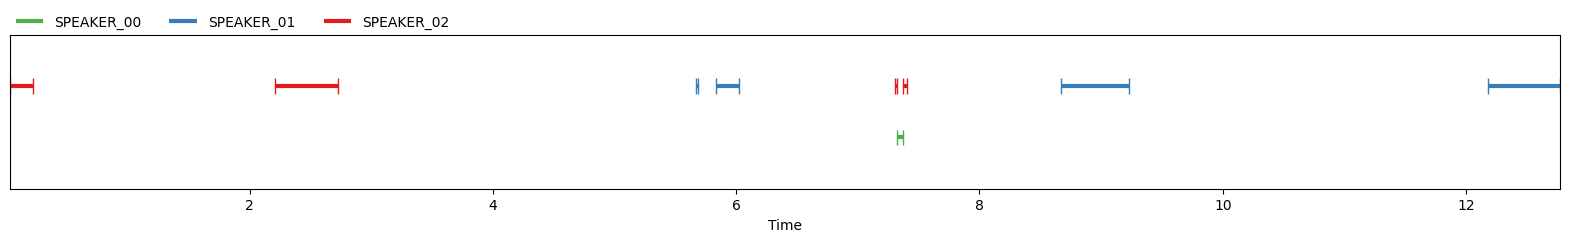

In [13]:
# we can use load_rttm to reload the rttm file

# Load the diarization output from the RTTM file
_, diary = load_rttm(r"C:\Users\caspar\OneDrive\LegoGPI\babyjokes\data\1_interim\2UWdXP.joke1.rep2.take1.Peekaboo_h265.diary.rttm").popitem()

diary

# 2.4 Voice fundamental frequency (F0) estimation

A simvple estimate is easy to get from `librosa`. So let's include it. Will use diarization to do it per utterance.

In [14]:
# Add F0 columns to processedvideos if they don't exist
if "F0.file" not in processedvideos.columns:
    processedvideos["F0.file"] = None
if "F0.when" not in processedvideos.columns:
    processedvideos["F0.when"] = None

# Process F0 for each video
forceF0 = False
for index, r in processedvideos.iterrows():
    if (forceF0 or pd.isnull(r["F0.file"])) and not pd.isnull(r["Audio.file"]):
        f0, voiced_flag, voiced_probs = find_f0(r["Audio.file"])
        
        # Save F0 data
        basename = os.path.basename(r["Audio.file"])
        filename, ext = os.path.splitext(basename)
        f0path = os.path.join(data_out, filename + ".f0.npz")
        np.savez(f0path, f0=f0, voiced_flag=voiced_flag, voiced_probs=voiced_probs)
        
        # Update record
        r["F0.file"] = f0path
        r["F0.when"] = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
        processedvideos.loc[index] = r

saveProcessedVideos(processedvideos, data_out)

NameError: name 'np' is not defined